# Classification project using Python

For this project we will build a classifier to predict whether a loan case will be paid off or not.

You load a historical dataset from previous loan applications, clean the data, and apply different classification algorithm on the data. We will use the following algorithms that we learned in this course to build our models:

- k-Nearest Neighbour
- Decision Tree
- Support Vector Machine
- Logistic Regression

The results is reported as the accuracy of each classifier, using the following metrics when these are applicable:

- Jaccard index
- F1-score
- LogLoass

You can download the dataset [here](https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv).

# Import required libraries

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, jaccard_similarity_score, log_loss
%matplotlib inline

# About the dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [2]:
df = pd.read_csv('loan_train.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape
(346, 10)

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing
Let’s see how many of each class is in our data set

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Lets plot some columns to underestand data better:

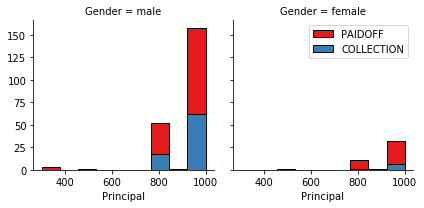

In [6]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

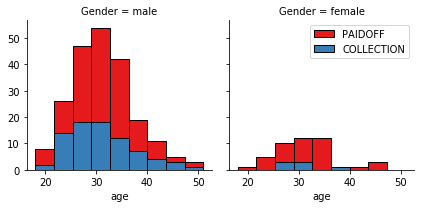

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

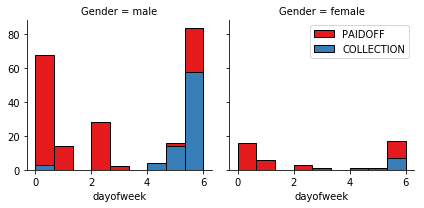

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:

In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [12]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Lets define the labels, y:

In [17]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

## Normalize Data 

Data Standardization gives data zero mean and unit variance.

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Train, test, split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


Now we are going to use the training set to build an accurate model. Then we will use the test set to report the accuracy of the model.

We will use the following algorithm:

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)

Classifier implementing the k-nearest neighbors vote.

### Training
Lets start the algorithm with k=4 for now:

In [20]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

### Predicting
we can use the model to predict the test set:

In [21]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 1, 0, 0], dtype=int64)

# Accuracy evaluation
In multilabel classification, accuracy classification score is a function that computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [22]:
print("Train set Jaccard score: ", metrics.jaccard_similarity_score(y_train, neigh.predict(X_train)))
print("Test set Jaccard score: ", metrics.jaccard_similarity_score(y_test, yhat))

Train set Jaccard score:  0.8108108108108109
Test set Jaccard score:  0.7701149425287356
----------------------------------------------
Train set Log loss score:  6.5343877997299815
Test set Log loss score:  7.9399853596314305


Algorithm with k=6

In [23]:
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)


print("Train set Jaccard score: ", metrics.jaccard_similarity_score(y_train, neigh6.predict(X_train)))
print("Test set Jaccard score: ", metrics.jaccard_similarity_score(y_test, yhat6))

Train set Jaccard score:  0.8185328185328186
Test set Jaccard score:  0.735632183908046
----------------------------------------------
f1 score:  0.2580645161290322


In [24]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [25]:
find_best_k(X_train, y_train, X_test, y_test)

Best Value for k: 7
F1-Score: 0.4444444444444444


# Decision trees modeling
We will first create an instance of the DecisionTreeClassifier called tree.
Inside of the classifier, specify criterion="entropy" so we can see the information gain of each node.

In [26]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Next, we will fit the data with the training feature matrix X_trainset and training response vector y_trainset

In [27]:
tree.fit(X_train ,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Prediction
Let's make some predictions on the testing dataset and store it into a variable called predTree.

In [28]:
predTree = tree.predict(X_test)

You can print out predTree and y_testset if you want to visually compare the prediction to the actual values.

In [29]:
print (predTree [0:5])
print (y_test [0:5])

[0 0 0 0 0]
[1 1 1 0 1]


# Evaluation

In [30]:
print("Train set Jaccard score: ", metrics.jaccard_similarity_score(y_train, tree.predict(X_train)))
print("Test set Jaccard score: ", metrics.jaccard_similarity_score(y_test, yhat))

Train set Jaccard score:  0.7567567567567568
Test set Jaccard score:  0.7701149425287356


Another way of looking at accuracy of classifier is to look at confusion matrix.

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[0,1]))

[[61  4]
 [16  6]]


Confusion matrix, without normalization
[[65  0]
 [22  0]]


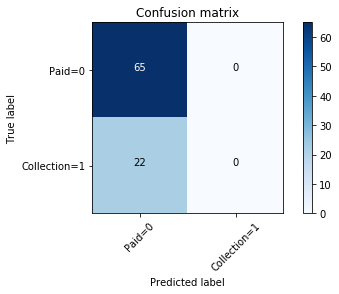

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=[0,1])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=0','Collection=1'],normalize= False,  title='Confusion matrix')

In [33]:
print (classification_report(y_test, predTree))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        65
           1       0.00      0.00      0.00        22

   micro avg       0.75      0.75      0.75        87
   macro avg       0.37      0.50      0.43        87
weighted avg       0.56      0.75      0.64        87



C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Modeling (SVM with Scikit-learn)

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

1. Linear
2. Polynomial
3. Radial basis function (RBF)
4. Sigmoid

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [34]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

After being fitted, the model can then be used to predict new values:

In [35]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0], dtype=int64)

# Evaluation

In [36]:
print("Train set Jaccard score: ", metrics.jaccard_similarity_score(y_train, clf.predict(X_train)))
print("Test set Jaccard score: ", metrics.jaccard_similarity_score(y_test, yhat))

Train set Jaccard score:  0.7722007722007722
Test set Jaccard score:  0.7586206896551724


              precision    recall  f1-score   support

           0       0.76      0.98      0.86        65
           1       0.67      0.09      0.16        22

   micro avg       0.76      0.76      0.76        87
   macro avg       0.71      0.54      0.51        87
weighted avg       0.74      0.76      0.68        87

Confusion matrix, without normalization
[[64  1]
 [20  2]]


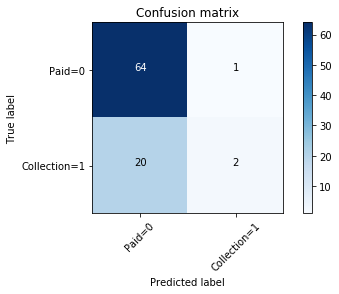

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=0','Collection=1'],normalize= False,  title='Confusion matrix')

In [38]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86        65
           1       0.67      0.09      0.16        22

   micro avg       0.76      0.76      0.76        87
   macro avg       0.71      0.54      0.51        87
weighted avg       0.74      0.76      0.68        87



Rebuild the model, but this time with a __linear__ kernel

In [39]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)

print("Train set Jaccard score: ", metrics.jaccard_similarity_score(y_train, clf2.predict(X_train)))
print("Test set Jaccard score: ", metrics.jaccard_similarity_score(y_test, yhat2))
print('----------------------------------------------')
print("f1 score: ", metrics.f1_score(y_test, yhat2))

Train set Jaccard score:  0.752895752895753
Test set Jaccard score:  0.7471264367816092
----------------------------------------------
f1 score:  0.0


C:\Users\luigi\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Modeling (Logistic Regression with Scikit-learn)

Lets build our model using LogisticRegression from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization. Now lets fit our model with train set:

In [40]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Now we can predict using our test set:

In [41]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

Predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):

In [42]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.51, 0.49],
       [0.7 , 0.3 ],
       [0.5 , 0.5 ],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.5 , 0.5 ],
       [0.68, 0.32],
       [0.59, 0.41],
       [0.66, 0.34],
       [0.68, 0.32],
       [0.69, 0.31],
       [0.57, 0.43],
       [0.51, 0.49],
       [0.69, 0.31],
       [0.52, 0.48],
       [0.52, 0.48],
       [0.5 , 0.5 ],
       [0.67, 0.33],
       [0.59, 0.41],
       [0.51, 0.49],
       [0.66, 0.34],
       [0.69, 0.31],
       [0.57, 0.43],
       [0.55, 0.45],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.67, 0.33],
       [0.68, 0.32],
       [0.51, 0.49],
       [0.56, 0.44],
       [0.55, 0.45],
       [0.56, 0.44],
       [0.69, 0.31],
       [0.72, 0.28],
       [0.53, 0.47],
       [0.66, 0.34],
       [0.7 , 0.3 ],
       [0.5 , 0.5 ],
       [0.54, 0.46],
       [0.51, 0.49],
       [0.57, 0.43],
       [0.69, 0.31],
       [0.52, 0.48],
       [0.73, 0.27],
       [0.55, 0.45],
       [0.67, 0.33],
       [0.73, 0.27],
       [0.51,

# Evaluation

In [43]:
print("Train set Jaccard score: ", metrics.jaccard_similarity_score(y_train, LR.predict(X_train)))
print("Test set Jaccard score: ", metrics.jaccard_similarity_score(y_test, yhat))
print('----------------------------------------------')
print("Train set Log loss score: ", metrics.log_loss(y_train, LR.predict(X_train)))
print("Test set Log loss score: ", metrics.log_loss(y_test, yhat))

Train set Jaccard score:  0.7644787644787645
Test set Jaccard score:  0.7701149425287356
----------------------------------------------
Train set Log loss score:  8.134618377169815
Test set Log loss score:  7.939948596531192


Another way of looking at accuracy of classifier is to look at confusion matrix.

Confusion matrix, without normalization
[[65  0]
 [20  2]]


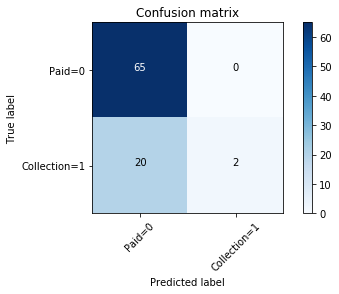

In [44]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=0','Collection=1'],normalize= False,  title='Confusion matrix')

In [45]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        65
           1       1.00      0.09      0.17        22

   micro avg       0.77      0.77      0.77        87
   macro avg       0.88      0.55      0.52        87
weighted avg       0.82      0.77      0.69        87



# Report

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.77       | 0.44        | NA      |
| Decision Tree      | 0.77       | 0.64        | NA      |
| SVM                | 0.76       | 0.68        | NA      |
| LogisticRegression | 0.77       | 0.7        | 7.94       |